In [30]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("../")
from sklearn.metrics import mean_squared_error
import re

In [49]:
distances=[2,4,10,20,25,35]
saved_models = '/storage/yw18581/src/leaf_reco/saved_models/trained_6positions/'

In [50]:
import numpy as np

In [51]:
regex = re.compile(r'\d+')

In [52]:
%matplotlib inline

In [53]:
from setenv import add_folders

In [54]:
add_folders(key="deepthought")

In [55]:
from utility_functions import define_dataset, training_phase_rUNet, inference_phase_rUNet, exclude_dist, inference_phase_rUNet_plot_notebook

In [56]:
from cUNet_pytorch_pooling import cUNet

In [57]:
import torch

In [58]:
DATA_DIR_DEEPTHOUGHT = "/storage/yw18581/data"

In [59]:
data_dir = DATA_DIR_DEEPTHOUGHT

In [60]:
root_folder = os.path.join(data_dir, "dataset")

In [61]:
excluded = exclude_dist(dist_list=distances, root_folder=root_folder)

In [62]:
excluded

['10x10_2mm_second_clean',
 '10x10_2mm_third_clean',
 '10x10_2mm_first_clean',
 '10x10_2mm_first',
 '10x10_2mm_second',
 '10x10_2mm_third',
 '10x10_4mm_second_clean',
 '10x10_4mm_third_clean',
 '10x10_4mm_first_clean',
 '10x10_4mm_first',
 '10x10_4mm_second',
 '10x10_4mm_third',
 '10x10_10mm_second_clean',
 '10x10_10mm_third_clean',
 '10x10_10mm_first_clean',
 '10x10_10mm_first',
 '10x10_10mm_second',
 '10x10_10mm_third',
 '10x10_20mm_second_clean',
 '10x10_20mm_third_clean',
 '10x10_20mm_first_clean',
 '10x10_20mm_first',
 '10x10_20mm_second',
 '10x10_20mm_third',
 '10x10_25mm_second_clean',
 '10x10_25mm_third_clean',
 '10x10_25mm_first_clean',
 '10x10_25mm_first',
 '10x10_25mm_second',
 '10x10_25mm_third',
 '10x10_35mm_second_clean',
 '10x10_35mm_third_clean',
 '10x10_35mm_first_clean',
 '10x10_35mm_first',
 '10x10_35mm_second',
 '10x10_35mm_third']

In [63]:
data_loaders, data_lengths= define_dataset(root_folder, batch_size=16, excluded_list=excluded, alldata=True)

In [64]:
data_lengths

3532

In [65]:
model_names = os.listdir(saved_models)

In [66]:
model_names

['Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl',
 'history_Trained_rUNet_pytorch_50epochs_0.75coef.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl',
 'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl',


In [67]:
def get_fnames(key):
    f_list = []
    epochs = []
    for fname in model_names:
        if fname.startswith("Trained"):
            if regex.findall(fname.split("_")[6])[1]==str(key):
                f_list.append(fname)
                epochs.append(int(regex.findall(fname.split("_")[5])[0]))
    return f_list, epochs

In [68]:
get_fnames(75)

(['Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_35epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_40epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_45epochs_0.75coeff_mask.pkl',
  'Trained_rUNet_pytorch_6positions_dataset_50epochs_0.75coeff_mask.pkl'],
 [5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [92]:
def mse_vs_epochs(coeff):
    mse = []
    f_list, epochs = get_fnames(coeff)
    for fname, e in zip(f_list, epochs):
        print(fname, e)
        torch.cuda.empty_cache()
        model= cUNet(out_size=1)
        checkpoint = torch.load(os.path.join(saved_models, fname))['model_state_dict'];
        model.load_state_dict(checkpoint)
        y_true, y_pred = inference_phase_rUNet(model, data_loaders, data_lengths, batch_size=16,
                                               notebook=True, test=False)
        np.savez_compressed(os.path.join(saved_models, '_'.join(['predicted',
                                                                 'unseen',
                                                                 fname.split('_')[3],
                                                                 fname.split('_')[5],
                                                                 fname.split('_')[6]])
                                         +'.npz'), true=y_true, pred=y_pred)
        mse.append(mean_squared_error(y_true, y_pred))
        
    plt.plot(epochs, mse)
    return mse, epochs

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl 30


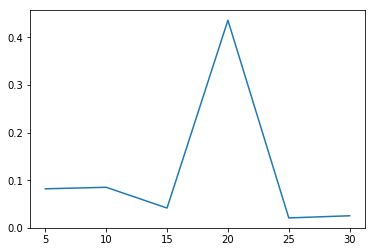

In [65]:
mse075, epochs = mse_vs_epochs(75)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.7coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.7coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.7coeff_mask.pkl 30


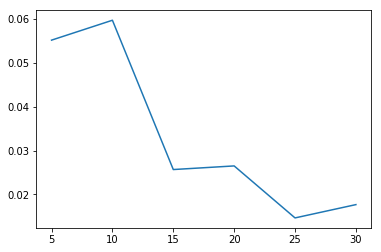

In [66]:
mse070, epochs = mse_vs_epochs(7)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.6coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.6coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.6coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.6coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.6coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.6coeff_mask.pkl 30


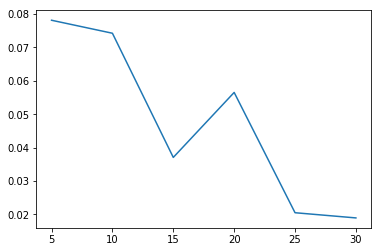

In [67]:
mse060, epochs = mse_vs_epochs(6)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.5coeff_mask.pkl 5



Trained_rUNet_pytorch_6positions_dataset_10epochs_0.5coeff_mask.pkl 10



Trained_rUNet_pytorch_6positions_dataset_15epochs_0.5coeff_mask.pkl 15



Trained_rUNet_pytorch_6positions_dataset_20epochs_0.5coeff_mask.pkl 20



Trained_rUNet_pytorch_6positions_dataset_25epochs_0.5coeff_mask.pkl 25



Trained_rUNet_pytorch_6positions_dataset_30epochs_0.5coeff_mask.pkl 30


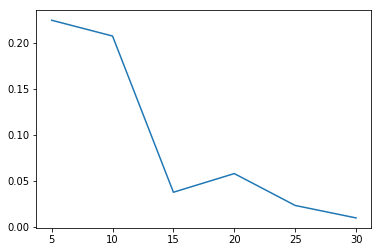

In [68]:
mse050, epochs = mse_vs_epochs(5)

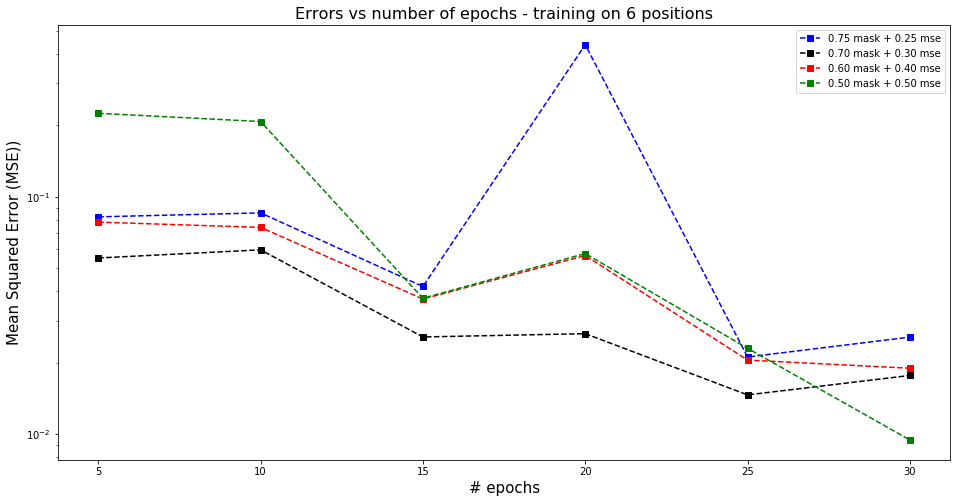

In [71]:
fig1, ax1 = plt.subplots(figsize=(16,8))
plt.title("Errors vs number of epochs - training on 6 positions",size=16)
ax1.plot(epochs, mse075, 's--', linewidth=1.5, c='blue',label='0.75 mask + 0.25 mse')
ax1.plot(epochs, mse070,'s--', linewidth=1.5, c='k', label='0.70 mask + 0.30 mse')
ax1.plot(epochs, mse060, 's--', linewidth=1.5, c='red', label='0.60 mask + 0.40 mse')
ax1.plot(epochs, mse050, 's--', linewidth=1.5, c='green', label='0.50 mask + 0.50 mse')
#ax1.plot(epochs, errors_250_4, 's--', linewidth=1.5, c='magenta', label='250 epochs_unseen')
#ax1.plot(epochs, errors_300_4, 's--', linewidth=1.5, c='orange', label='300 epochs_unseen')

ax1.set_ylabel("Mean Squared Error (MSE))", size=15)
#ax1.set_xticks(np.arange(1,36,1))#[1,2,3,4,10,15,20,25,30,35])
ax1.set_xlabel("# epochs", size=15)
ax1.set_yscale('log')
ax1.legend(loc='upper right')
plt.show()

In [19]:
data_loaders_mask, data_lengths_mask = define_dataset(root_folder, batch_size=2, excluded_list=excluded)

In [20]:
def masks_vs_epochs(coeff):
    f_list, epochs = get_fnames(coeff)
    for fname, e in zip(f_list, epochs):
        print(fname, e)
        torch.cuda.empty_cache()
        model= cUNet(out_size=1)
        checkpoint = torch.load(os.path.join(saved_models, 
                                                      fname))['model_state_dict'];
        model.load_state_dict(checkpoint)
        inference_phase_rUNet_plot_notebook(model, data_loaders_mask, data_lengths_mask, batch_size=2,
                                               stop=1, test=False)
    return 

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.75coeff_mask.pkl 5


batch 1
1: true_dist: 2, pred_dist: [2.1877048]


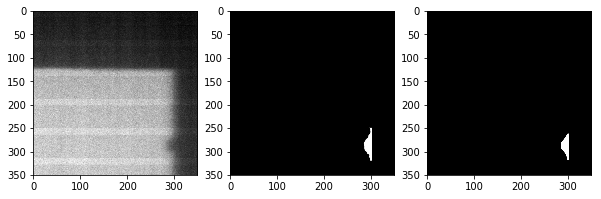

2: true_dist: 4, pred_dist: [3.5918865]


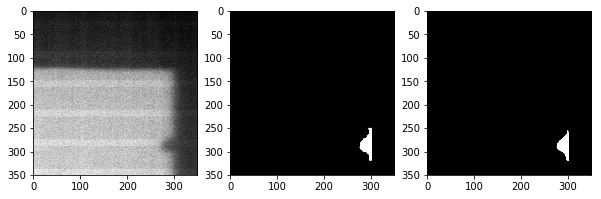

Trained_rUNet_pytorch_6positions_dataset_10epochs_0.75coeff_mask.pkl 10



batch 1
1: true_dist: 10, pred_dist: [9.837965]


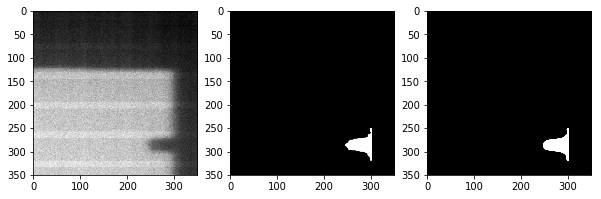

2: true_dist: 25, pred_dist: [24.735254]


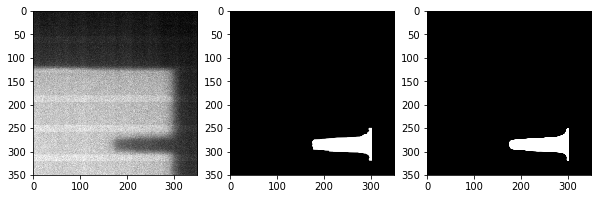

Trained_rUNet_pytorch_6positions_dataset_15epochs_0.75coeff_mask.pkl 15


batch 1
1: true_dist: 35, pred_dist: [35.082523]


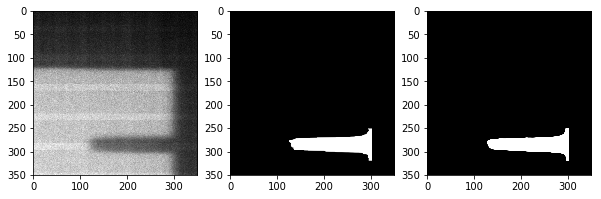

2: true_dist: 10, pred_dist: [10.051516]


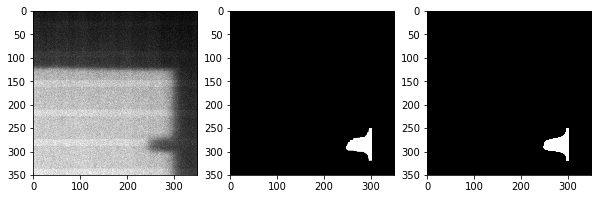

Trained_rUNet_pytorch_6positions_dataset_20epochs_0.75coeff_mask.pkl 20


batch 1
1: true_dist: 35, pred_dist: [35.90242]


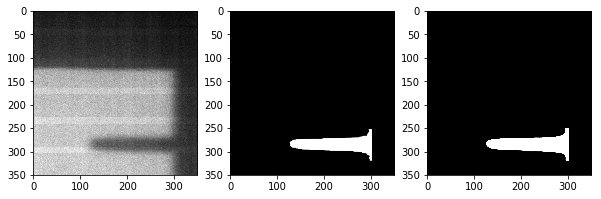

2: true_dist: 2, pred_dist: [2.1753216]


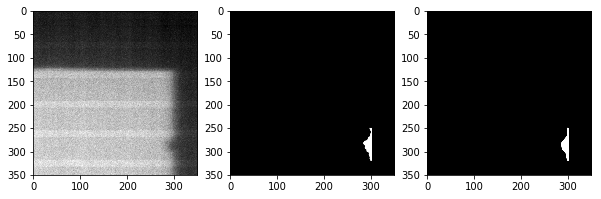

Trained_rUNet_pytorch_6positions_dataset_25epochs_0.75coeff_mask.pkl 25


batch 1
1: true_dist: 35, pred_dist: [34.967957]





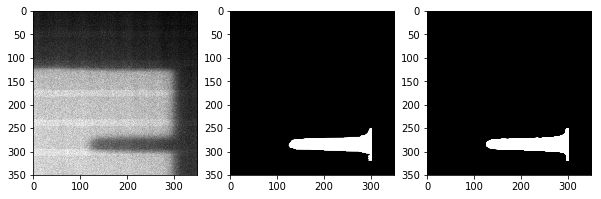

2: true_dist: 10, pred_dist: [10.176714]


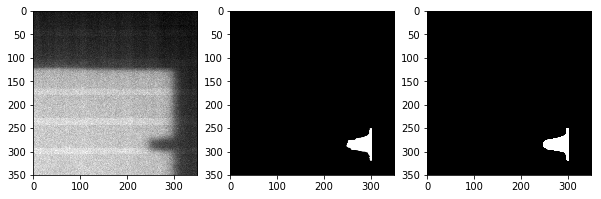

Trained_rUNet_pytorch_6positions_dataset_30epochs_0.75coeff_mask.pkl 30


batch 1
1: true_dist: 4, pred_dist: [3.9357727]


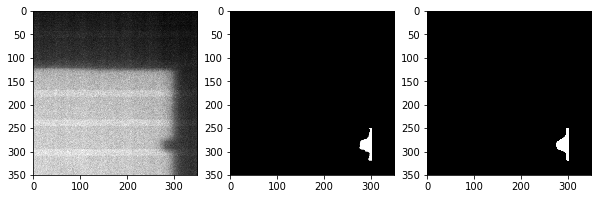

2: true_dist: 4, pred_dist: [4.0003824]


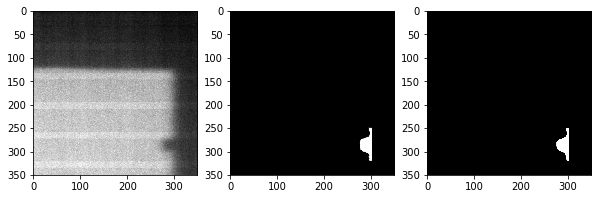

In [21]:
masks_vs_epochs(75)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.7coeff_mask.pkl 5


batch 1
1: true_dist: 2, pred_dist: [2.020643]


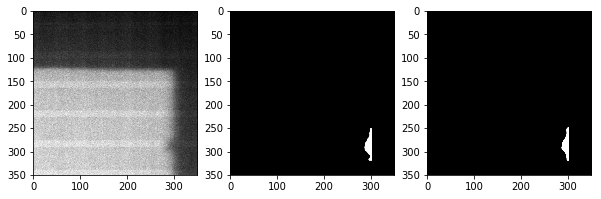

2: true_dist: 10, pred_dist: [10.026874]


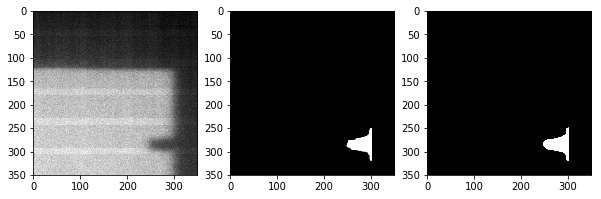

Trained_rUNet_pytorch_6positions_dataset_10epochs_0.7coeff_mask.pkl 10


batch 1
1: true_dist: 20, pred_dist: [19.996443]


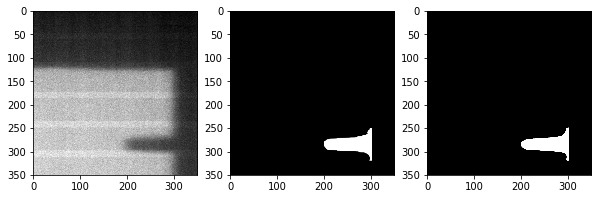

2: true_dist: 35, pred_dist: [34.7476]


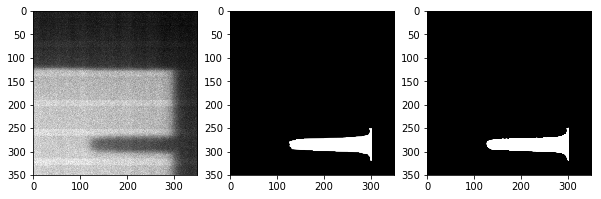

Trained_rUNet_pytorch_6positions_dataset_15epochs_0.7coeff_mask.pkl 15


batch 1
1: true_dist: 25, pred_dist: [24.886127]


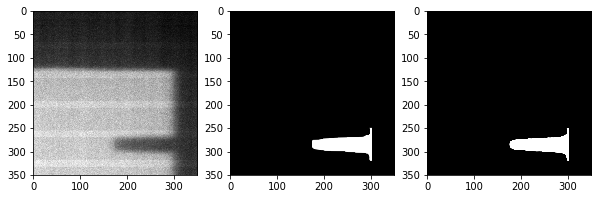

2: true_dist: 25, pred_dist: [25.019392]


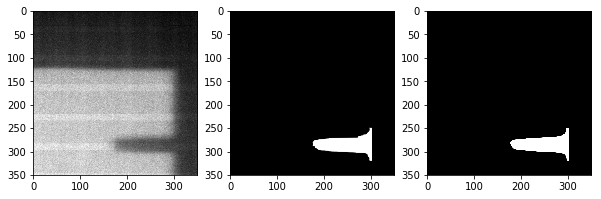

Trained_rUNet_pytorch_6positions_dataset_20epochs_0.7coeff_mask.pkl 20


batch 1
1: true_dist: 2, pred_dist: [2.018861]


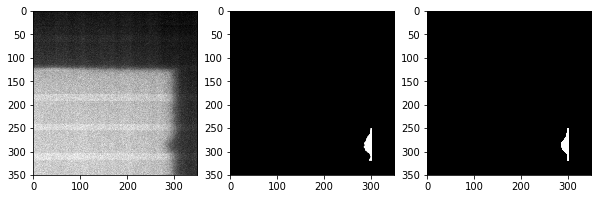

2: true_dist: 35, pred_dist: [35.105846]


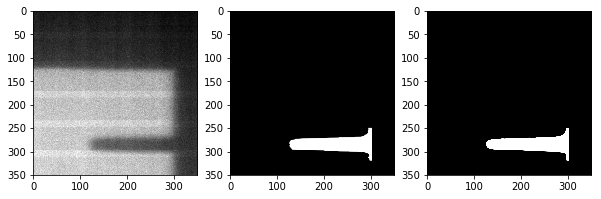

Trained_rUNet_pytorch_6positions_dataset_25epochs_0.7coeff_mask.pkl 25


batch 1
1: true_dist: 2, pred_dist: [1.9815624]




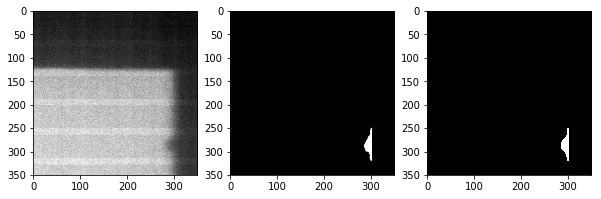

2: true_dist: 2, pred_dist: [1.8598224]


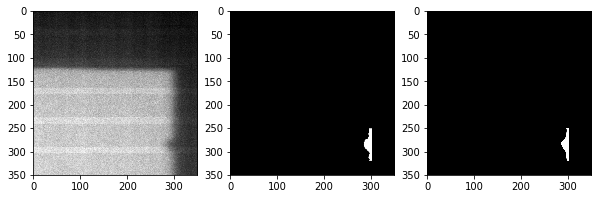

Trained_rUNet_pytorch_6positions_dataset_30epochs_0.7coeff_mask.pkl 30


batch 1
1: true_dist: 35, pred_dist: [34.775543]


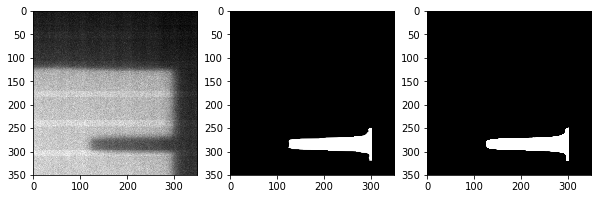

2: true_dist: 20, pred_dist: [19.899132]


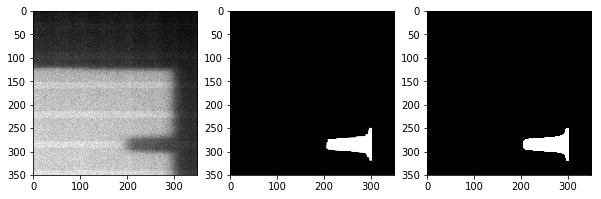

In [22]:
masks_vs_epochs(7)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.6coeff_mask.pkl 5


batch 1
1: true_dist: 25, pred_dist: [25.006077]


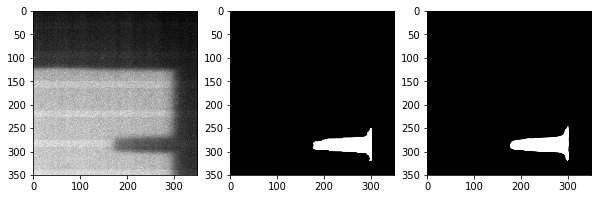

2: true_dist: 20, pred_dist: [20.102848]


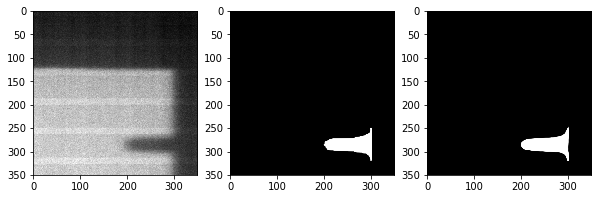

Trained_rUNet_pytorch_6positions_dataset_10epochs_0.6coeff_mask.pkl 10


batch 1
1: true_dist: 20, pred_dist: [20.18167]



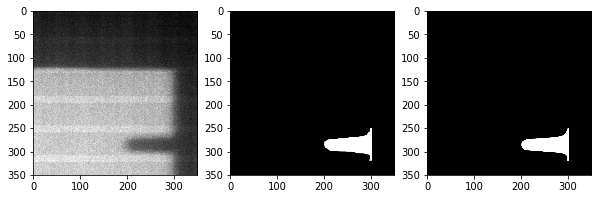

2: true_dist: 20, pred_dist: [20.084871]


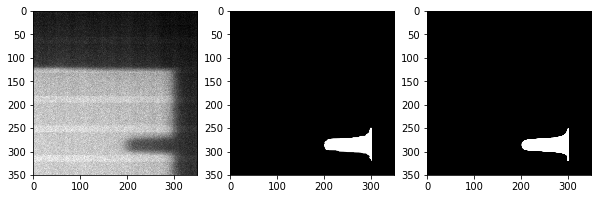

Trained_rUNet_pytorch_6positions_dataset_15epochs_0.6coeff_mask.pkl 15


batch 1
1: true_dist: 35, pred_dist: [35.18154]


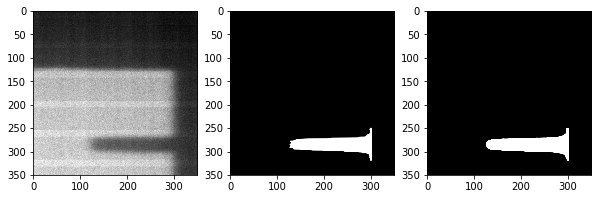

2: true_dist: 4, pred_dist: [3.8855443]


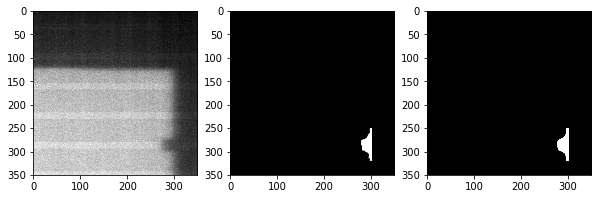

Trained_rUNet_pytorch_6positions_dataset_20epochs_0.6coeff_mask.pkl 20


batch 1
1: true_dist: 35, pred_dist: [35.127716]


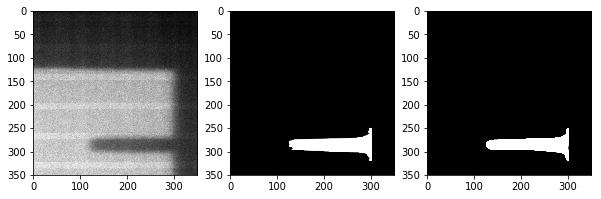

2: true_dist: 20, pred_dist: [20.12969]


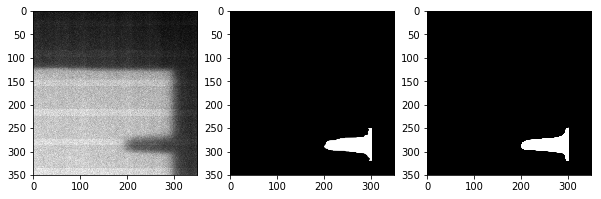

Trained_rUNet_pytorch_6positions_dataset_25epochs_0.6coeff_mask.pkl 25


batch 1
1: true_dist: 20, pred_dist: [19.930616]



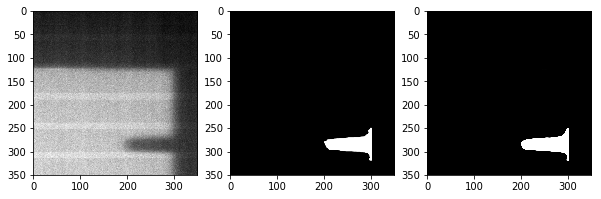

2: true_dist: 35, pred_dist: [35.027126]


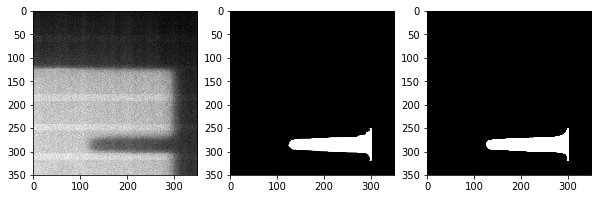

Trained_rUNet_pytorch_6positions_dataset_30epochs_0.6coeff_mask.pkl 30


batch 1
1: true_dist: 20, pred_dist: [19.79933]


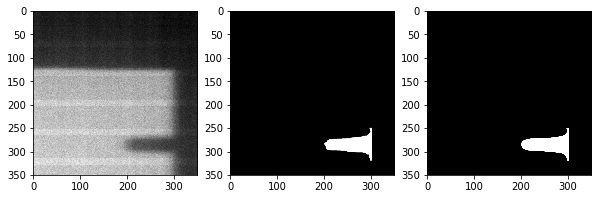

2: true_dist: 10, pred_dist: [9.899672]


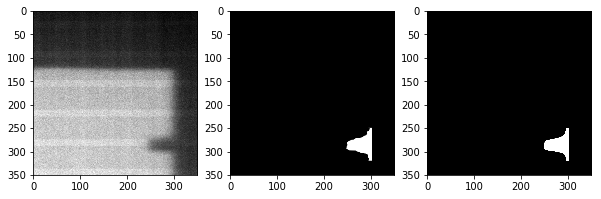

In [23]:
masks_vs_epochs(6)

Trained_rUNet_pytorch_6positions_dataset_5epochs_0.5coeff_mask.pkl 5


batch 1
1: true_dist: 35, pred_dist: [33.917854]


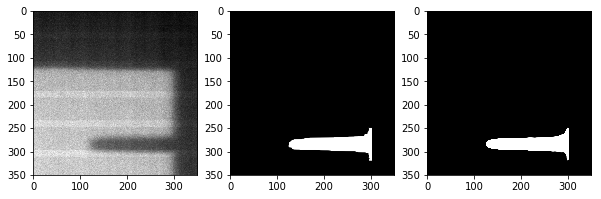

2: true_dist: 20, pred_dist: [19.408188]


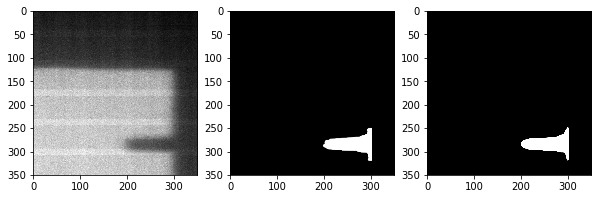

Trained_rUNet_pytorch_6positions_dataset_10epochs_0.5coeff_mask.pkl 10


batch 1
1: true_dist: 10, pred_dist: [9.56307]


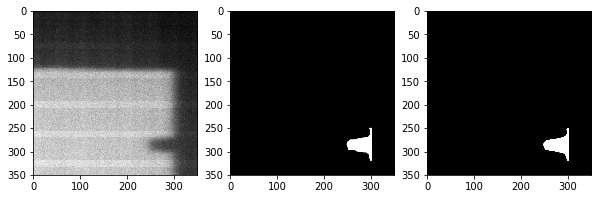

2: true_dist: 2, pred_dist: [1.7536273]


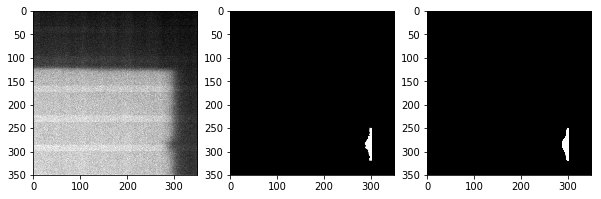

Trained_rUNet_pytorch_6positions_dataset_15epochs_0.5coeff_mask.pkl 15


batch 1
1: true_dist: 20, pred_dist: [19.95386]


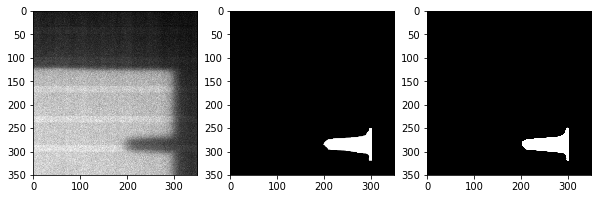

2: true_dist: 4, pred_dist: [3.918154]


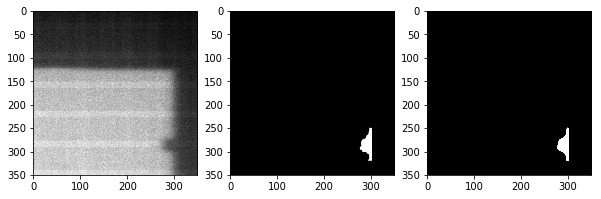

Trained_rUNet_pytorch_6positions_dataset_20epochs_0.5coeff_mask.pkl 20


batch 1
1: true_dist: 10, pred_dist: [9.850676]


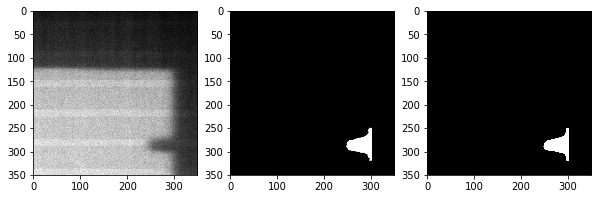

2: true_dist: 20, pred_dist: [19.92717]


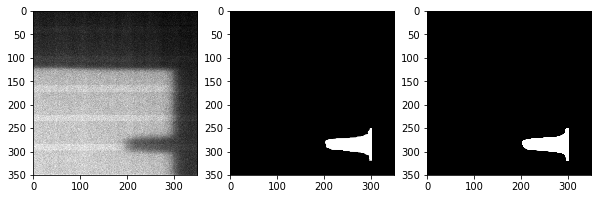

Trained_rUNet_pytorch_6positions_dataset_25epochs_0.5coeff_mask.pkl 25


batch 1
1: true_dist: 25, pred_dist: [25.150175]




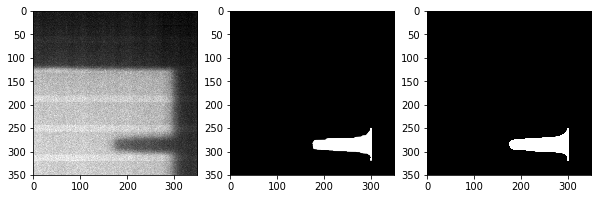

2: true_dist: 4, pred_dist: [4.0231285]


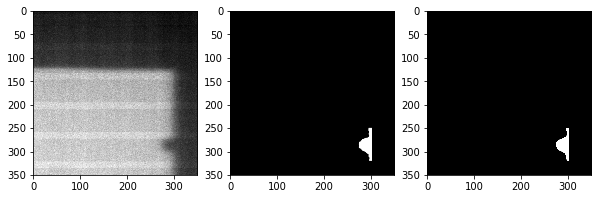

Trained_rUNet_pytorch_6positions_dataset_30epochs_0.5coeff_mask.pkl 30


batch 1
1: true_dist: 20, pred_dist: [20.162935]


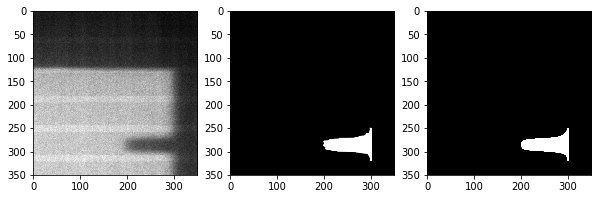

2: true_dist: 2, pred_dist: [2.0283043]


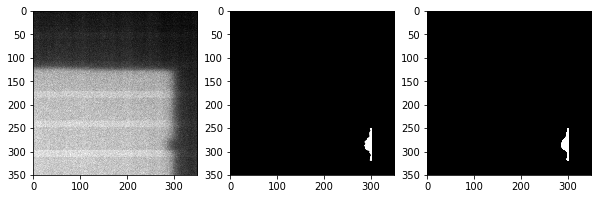

In [24]:
masks_vs_epochs(5)